In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import count
from scipy import ndimage
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm
import tensorflow_addons as tfa

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 32
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_augment"
PATH = ""

# Set seeds

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#x_train = preprocess(x_train)
#x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 14s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def CIFARmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Data augmentation functions


In [0]:
def flip_image(image):
    if np.random.rand() < 0.2:
        image = tf.image.flip_left_right(image)
    return image

In [0]:
def rotate_image(image):
    if np.random.rand() < 0.2:
        angles = np.linspace(1,10,10)
        rotation_angle = np.random.choice(angles)
        if np.random.rand() < 0.5:
            image = ndimage.rotate(image, rotation_angle, reshape = False)
        else:
            image = ndimage.rotate(image, -rotation_angle, reshape = False) 
    return image

In [0]:
def horizontal_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,-3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
def vertical_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,0], [0,1,2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,0], [0,1,-2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
funcs = [rotate_image,
         horizontal_shift, 
         vertical_shift]

# Train

In [0]:
models = []
accuracies = [0]

for i in range(len(funcs)):

    print(f"Train model {i}")

    preprocessing_function = funcs[i]
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    datagen = datagen.flow(x_train,y_train, batch_size = BATCH_SIZE)

    model = CIFARmodel(IMAGE_SIZE, NUM_CLASSES, 3)

    es = EarlyStopping(min_delta = 0.01, patience=3, restore_best_weights=True)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/9999
313/313 [==============================] - 9s 30ms/step - loss: 1.7383 - accuracy: 0.3882 - val_loss: 2.2444 - val_accuracy: 0.1144
Epoch 2/9999
313/313 [==============================] - 9s 28ms/step - loss: 1.3449 - accuracy: 0.5262 - val_loss: 1.4609 - val_accuracy: 0.4901
Epoch 3/9999
313/313 [==============================] - 9s 29ms/step - loss: 1.1831 - accuracy: 0.5840 - val_loss: 1.2315 - val_accuracy: 0.5601
Epoch 4/9999
313/313 [==============================] - 9s 28ms/step - loss: 1.0743 - accuracy: 0.6256 - val_loss: 1.1404 - val_accuracy: 0.5939
Epoch 5/9999
313/313 [==============================] - 9s 28ms/step - loss: 0.9920 - accuracy: 0.6552 - val_loss: 1.1081 - val_accuracy: 0.6013
Epoch 6/9999
313/313 [==============================] - 9s 28ms/step - loss: 0.9260 - accuracy: 0.6792 - val_loss: 1.1439 - val_accuracy: 0.5939
Epoch 7/9999
313/313 [==============================] - 9s 28ms/step - loss: 0.8655 - accuracy: 0.7020 - val_loss: 1

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Model: 0 added. Resulting score: 0.6672
Train model 1
Epoch 1/9999
313/313 [==============================] - 7s 21ms/step - loss: 1.7059 - accuracy: 0.3932 - val_loss: 2.2367 - val_accuracy: 0.1274
Epoch 2/9999
313/313 [==============================] - 6s 19ms/step - loss: 1.3456 - accuracy: 0.5239 - val_loss: 1.4317 - val_accuracy: 0.4987
Epoch 3/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.1953 - accuracy: 0.5804 - val_loss: 1.1999 - val_accuracy: 0.5735
Epoch 4/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0876 - accuracy: 0.6173 - val_loss: 1.1747 - val_accuracy: 0.5840
Epoch 5/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0046 - accuracy: 0.6500 - val_loss: 1.0983 - val_accuracy: 0.6158
Epoch 6/9999
313/313 [==============================] - 6s 20ms/step - loss: 0.9383 - accuracy: 0.6729 - val_loss: 1.0142 - val_accuracy: 0.6396
Epoch 7/9999
313/313 [==============================] - 6s 20ms/step - loss:

100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Model: 1 added. Resulting score: 0.6679
Train model 2
Epoch 1/9999
313/313 [==============================] - 7s 21ms/step - loss: 1.6719 - accuracy: 0.4041 - val_loss: 2.2865 - val_accuracy: 0.1195
Epoch 2/9999
313/313 [==============================] - 6s 19ms/step - loss: 1.3415 - accuracy: 0.5269 - val_loss: 1.5366 - val_accuracy: 0.4622
Epoch 3/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.1938 - accuracy: 0.5811 - val_loss: 1.4353 - val_accuracy: 0.4947
Epoch 4/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0890 - accuracy: 0.6186 - val_loss: 1.1529 - val_accuracy: 0.5910
Epoch 5/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0097 - accuracy: 0.6484 - val_loss: 1.1912 - val_accuracy: 0.5810
Epoch 6/9999
313/313 [==============================] - 6s 20ms/step - loss: 0.9442 - accuracy: 0.6730 - val_loss: 1.2122 - val_accuracy: 0.5870
Epoch 7/9999
313/313 [==============================] - 6s 20ms/step - loss:

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

Model: 2 added. Resulting score: 0.7062


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [0]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.0000,0
1,0.6672,1
2,0.6679,2
3,0.7062,3


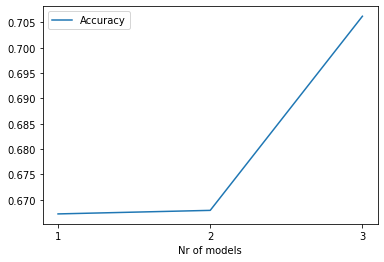

In [0]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [0]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

Accuracy: 0.6999


In [0]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))



100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


## Correlation between models

In [0]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,np.argmax(y_test, axis = 1))])

100%|██████████| 3/3 [00:00<00:00, 307.02it/s]


In [0]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2
0,NaN,0.687528,0.691849
1,0.687528,NaN,0.687641
2,0.691849,0.687641,NaN


Average correlation: 0.6890058153767168
